In [1]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import tqdm.notebook as tq
import time
from skimage.color import rgb2hsv
from skimage.feature import local_binary_pattern

# Import Dataset

There are 6 folders containing pictures divided into the 6 movements

Labels will be one-hot.

In [2]:
main_folder_path = "./Data/faces_6class"

class_folders = sorted(os.listdir(main_folder_path))
num_classes = len(class_folders)

labels = {}  # Dictionary to map class names to one-hot labels
for i, class_folder in enumerate(class_folders):
    labels[class_folder] = i

images = []
one_hot_labels = []

for class_folder in class_folders:
    class_path = os.path.join(main_folder_path, class_folder)
    class_label = labels[class_folder]
    
    for image_file in os.listdir(class_path):
        #print(image_file)
        image_path = os.path.join(class_path, image_file)
        img = Image.open(image_path)
        
        # Process the image as needed (e.g., resize, normalize)
        img = img.resize((400, 400))
        
        #print(img.size)
                
        # Append the image to the list of images
        images.append(np.array(img))
        
        # Create a one-hot label vector
        one_hot = np.zeros(num_classes)
        one_hot[class_label] = 1
        one_hot_labels.append(one_hot)

# Convert images and labels to numpy arrays
images = np.array(images)
one_hot_labels = np.array(one_hot_labels)

# Now, you have your images in the 'images' array and corresponding one-hot label vectors in 'one_hot_labels'.
# You can use these data for machine learning tasks.

# Shuffle the dataset
Since the images are divided by class, we shuffle the dataset to have a sparser dataset

In [3]:
# Get the number of samples
num_samples = len(images)

# Create a permutation index
permutation = np.random.permutation(num_samples)

# Shuffle both 'images' and 'labels' using the same permutation
shuffled_images = images[permutation]
shuffled_labels = one_hot_labels[permutation]

# Dataset Class

In [4]:
# Define the custom class for accessing our dataset
class DatasetRGB(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels=labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # returns a training sample and its label
        element = self.images[idx]
        label = torch.tensor(self.labels[idx])
        element = torch.tensor(element) 
                
        return element, label

# Train and Test functions

In [78]:
def test(model, validation_dataset, y_validation, RGB = False, is_ensamble = False, normalized_cm = False):
    # Stop parameters learning
    model.eval()

    validation_loader = torch.utils.data.DataLoader(validation_dataset)

    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0
    confusion_matrix = np.zeros((8, 8), dtype=int)
    i=0
    
    with torch.no_grad():
        for inputs, label in validation_loader:
            
            
            
            #predict label
            if RGB==True:
                output = model(inputs.permute(0, 3, 1, 2))
            else:
                output = model(inputs)
           
            
            # Compute loss
            loss = criterion(output, label)
            total_loss += loss.item()

            max_index = torch.argmax(output).item()  # The index with maximum probability

            
            correct += (max_index == torch.argmax(label).item())
            i+=1

    
    accuracy = 100 * correct / len(y_validation)
    average_loss = total_loss / len(y_validation)

    model.train()
    return accuracy, average_loss, confusion_matrix

In [6]:
def train(model, dataset, validation_dataset, batch_size, num_epochs, learning_rate, verbose = False,
          reg=1e-5, RGB = False, is_ensamble = False, normalized_cm=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    val_loss_list=[]
    val_acc_list=[]
    train_loss_list=[]
    train_acc_list=[]
    counted_labels=[0,0,0,0,0,0,0,0]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
    criterion = nn.CrossEntropyLoss()

    if not isinstance(dataset, Dataset):
        raise ValueError("The dataset parameter should be an instance of torch.utils.data.Dataset.")

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(data_loader)
    
    
    for epoch in range(num_epochs):
        running_loss = 0.0 
        running_accuracy = 0.0
        #initialize correctly predicted samples
        
        # Initialize the progress bar
        progress_bar = tq.tqdm(total=num_batches, unit="batch")
    
        # Initialize the progress bar description
        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()
        
        for batch_idx, batch in enumerate(data_loader):
            
            correct = 0 # reset train accuracy each batch
            
            inputs,labels = batch[0],batch[1]
            if(verbose == True):
                print("\ninputs shape:",inputs.size(),", dtype:",inputs.dtype," content: ",inputs)
                print("min value:",torch.min(inputs))
                print("max value:",torch.max(inputs))
                print("\nlabels shape:",labels.size(),",dtype:",labels.dtype,", content: ",labels)
          
            
            # Extract the inputs and targets
            optimizer.zero_grad()
            if RGB==True:
                inputs = inputs.permute(0, 3, 1, 2)
            outputs = model(inputs)
                        
            if(verbose == True):
                print("\noutputs size:",outputs.size(),"content:",outputs)
                print("List of labels until now:",counted_labels)

            loss = criterion(outputs, labels) #labels need to be a vector of class indexes (0-7) of dim (batch_size)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            #calculate train accuracy
            for index, output in enumerate(outputs):
                max_index = torch.argmax(output).item() #the index with maximum probability
                if(torch.argmax(labels[index]).item() == max_index):
                    correct += 1
            
                if(verbose==True):
                    print("considering output at index {}:".format(index,output))
                    print("max output index = {}",max_index)
                    if(labels[index].item() == max_index):
                        print("correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))
                    else:
                        print("NOT correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))

            
            accuracy = 100 * correct / batch_size
            running_accuracy += accuracy #epoch running_accuracy
            
            # Update the progress bar description and calculate bps
            #progress_bar.set_postfix({"Loss": running_loss / (batch_idx + 1)})
            average_accuracy = running_accuracy / (batch_idx + 1)
            average_loss = running_loss / (batch_idx + 1)
            progress_bar.set_postfix({"avg_loss": average_loss, "acc": accuracy, "avg_acc": average_accuracy})

            # Update the progress bar
            progress_bar.update(1)
            # Evaluate the model on the validation dataset
        
        #calculate train loss and accuracy
        average_loss = running_loss / len(data_loader)
        average_accuracy = running_accuracy / len(data_loader)
        train_loss_list.append(average_loss)
        train_acc_list.append(average_accuracy)
        
        #calculate validation loss and accuracy
        val_acc, val_loss,_ = test(model, validation_dataset, y_validation, RGB = RGB, is_ensamble = is_ensamble, normalized_cm=False)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {average_loss:.4f}. Train Accuracy: {average_accuracy} Val Loss: {val_loss} Val Accuracy: {val_acc}")
        progress_bar.close()
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

# Split into train, validation and test set

In [7]:
# Assuming you have 'shuffled_images' and 'shuffled_labels'

# Define the proportions for the splits (e.g., 60% train, 20% validation, 20% test)
train_percent = 0.6
validation_percent = 0.2

num_samples = len(shuffled_images)

train_size = int(train_percent * num_samples)
validation_size = int(validation_percent * num_samples)

x_train, x_validation, x_test = (
    shuffled_images[:train_size],
    shuffled_images[train_size:train_size + validation_size],
    shuffled_images[train_size + validation_size:]
)

y_train, y_validation, y_test = (
    shuffled_labels[:train_size],
    shuffled_labels[train_size:train_size + validation_size],
    shuffled_labels[train_size + validation_size:]
)

# Neural Network Architecture

In [27]:

class Raw_Images_NN(nn.Module):
    def __init__(self, num_classes):
        super(Raw_Images_NN, self).__init__()        
        # First convolutional layer with batch normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for the first convolutional layer
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=8)
        # First convolutional layer with batch normalization
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for the first convolutional layer
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=4)
        
        
        # Fully connected layers with batch normalization and dropout
        self.fc1 = nn.Linear(7744, 128)  # Adjust the input size accordingly
        self.bn3 = nn.BatchNorm1d(128)  # Batch normalization for the first linear layer
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)  # Dropout after the first linear layer
        
        self.fc3 = nn.Linear(128, 64)  # Add another linear layer
        self.bn4 = nn.BatchNorm1d(64)  # Batch normalization for the second linear layer
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)  # Dropout after the second linear layer
        
        self.fc4 = nn.Linear(64, 32)  # Add one more linear layer
        self.bn5 = nn.BatchNorm1d(32)  # Batch normalization for the third linear layer
        self.relu4 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)  # Dropout after the third linear layer
        
        self.fc5 = nn.Linear(32, num_classes)  # Output layer
        
    def forward(self, x):
        x = self.conv1(x.float())
        x = self.bn1(x)  # Apply batch normalization
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply batch normalization
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc1(x)
        x = self.bn3(x)  # Apply batch normalization
        x = self.relu2(x)
        x = self.dropout1(x)  # Apply dropout
        
        x = self.fc3(x)
        x = self.bn4(x)  # Apply batch normalization
        x = self.relu3(x)
        x = self.dropout2(x)  # Apply dropout
        
        x = self.fc4(x)
        x = self.bn5(x)  # Apply batch normalization
        x = self.relu4(x)
        x = self.dropout3(x)  # Apply dropout
        
        x = self.fc5(x)  # Output layer
        
        return x

In [28]:
train_set=DatasetRGB(x_train,y_train)
validation_set=DatasetRGB(x_validation,y_validation)
test_set=DatasetRGB(x_test,y_test)

In [29]:
model=Raw_Images_NN(6)
train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model, train_set,validation_set, batch_size=16, num_epochs=50, learning_rate=0.001, reg=1e-5)


  0%|          | 0/35 [00:00<?, ?batch/s]

KeyboardInterrupt: 

# Use of Features

## HSV Color Ratio

In [8]:

def HSVprocess(tmpimage,variance):
    #print("A")
    image = rgb2hsv(tmpimage)
    vert, oriz, plane = image.shape
    MAPPING = None  # You can provide the LBP mapping here if needed

    # Initialize ratio images
    hs = np.zeros((vert, oriz))
    sv = np.zeros((vert, oriz))
    hv = np.zeros((vert, oriz))

    # Get ratio values of each pixel
    for i in range(vert):
        for j in range(oriz):
            if variance == 1:
                sumH, sumS, sumV = 0, 0, 0

                # Bit in the middle
                sumH += image[i, j, 0]
                sumS += image[i, j, 1]
                sumV += image[i, j, 2]

                # Check other bits around to avoid errors and sum them if possible
                if i > 0:
                    sumH += image[i - 1, j, 0]
                    sumS += image[i - 1, j, 1]
                    sumV += image[i - 1, j, 2]

                    if j > 0:
                        sumH += image[i - 1, j - 1, 0]
                        sumS += image[i - 1, j - 1, 1]
                        sumV += image[i - 1, j - 1, 2]

                    if j < oriz - 1:
                        sumH += image[i - 1, j + 1, 0]
                        sumS += image[i - 1, j + 1, 1]
                        sumV += image[i - 1, j + 1, 2]

                if i < vert - 1:
                    sumH += image[i + 1, j, 0]
                    sumS += image[i + 1, j, 1]
                    sumV += image[i + 1, j, 2]

                    if j > 0:
                        sumH += image[i + 1, j - 1, 0]
                        sumS += image[i + 1, j - 1, 1]
                        sumV += image[i + 1, j - 1, 2]

                    if j < oriz - 1:
                        sumH += image[i + 1, j + 1, 0]
                        sumS += image[i + 1, j + 1, 1]
                        sumV += image[i + 1, j + 1, 2]

                if j < oriz - 1:
                    sumH += image[i, j + 1, 0]
                    sumS += image[i, j + 1, 1]
                    sumV += image[i, j + 1, 2]

                if j > 0:
                    sumH += image[i, j - 1, 0]
                    sumS += image[i, j - 1, 1]
                    sumV += image[i, j - 1, 2]

                if i > 1:
                    sumH += image[i - 2, j, 0]
                    sumS += image[i - 2, j, 1]
                    sumV += image[i - 2, j, 2]

                    if j > 0:
                        sumH += image[i - 2, j - 1, 0]
                        sumS += image[i - 2, j - 1, 1]
                        sumV += image[i - 2, j - 1, 2]

                    if j < oriz - 1:
                        sumH += image[i - 2, j + 1, 0]
                        sumS += image[i - 2, j + 1, 1]
                        sumV += image[i - 2, j + 1, 2]

                    if j > 1:
                        sumH += image[i - 2, j - 2, 0]
                        sumS += image[i - 2, j - 2, 1]
                        sumV += image[i - 2, j - 2, 2]

                    if j < oriz - 2:
                        sumH += image[i - 2, j + 2, 0]
                        sumS += image[i - 2, j + 2, 1]
                        sumV += image[i - 2, j + 2, 2]

                if i < vert - 2:
                    sumH += image[i + 2, j, 0]
                    sumS += image[i + 2, j, 1]
                    sumV += image[i + 2, j, 2]

                    if j > 0:
                        sumH += image[i + 2, j - 1, 0]
                        sumS += image[i + 2, j - 1, 1]
                        sumV += image[i + 2, j - 1, 2]

                    if j < oriz - 1:
                        sumH += image[i + 2, j + 1, 0]
                        sumS += image[i + 2, j + 1, 1]
                        sumV += image[i + 2, j + 1, 2]

                    if j > 1:
                        sumH += image[i + 2, j - 2, 0]
                        sumS += image[i + 2, j - 2, 1]
                        sumV += image[i + 2, j - 2, 2]

                    if j < oriz - 2:
                        sumH += image[i + 2, j + 2, 0]
                        sumS += image[i + 2, j + 2, 1]
                        sumV += image[i + 2, j + 2, 2]

                if j > 1:
                    sumH += image[i, j - 2, 0]
                    sumS += image[i, j - 2, 1]
                    sumV += image[i, j - 2, 2]

                    if i > 0:
                        sumH += image[i - 1, j - 2, 0]
                        sumS += image[i - 1, j - 2, 1]
                        sumV += image[i - 1, j - 2, 2]

                    if i < vert - 1:
                        sumH += image[i + 1, j - 2, 0]
                        sumS += image[i + 1, j - 2, 1]
                        sumV += image[i + 1, j - 2, 2]

                if j < oriz - 2:
                    sumH += image[i, j + 2, 0]
                    sumS += image[i, j + 2, 1]
                    sumV += image[i, j + 2, 2]

                    if i > 0:
                        sumH += image[i - 1, j + 2, 0]
                        sumS += image[i - 1, j + 2, 1]
                        sumV += image[i - 1, j + 2, 2]

                    if i < vert - 1:
                        sumH += image[i + 1, j + 2, 0]
                        sumS += image[i + 1, j + 2, 1]
                        sumV += image[i + 1, j + 2, 2]

                # New Pixel Value, calculated with the ratio of the sum
                hs[i, j] = np.log((sumH + 1e-12) / (sumS + 1e-12))
                sv[i, j] = np.log((sumS + 1e-12) / (sumV + 1e-12))
                hv[i, j] = np.log((sumH + 1e-12) / (sumV + 1e-12))

            elif variance == 2:
                # Second variance of the feature, there's no window, the ratio goes within the pixel
                hs[i, j] = np.log((image[i, j, 0] + 1e-12) / (image[i, j, 1] + 1e-12))
                sv[i, j] = np.log((image[i, j, 1] + 1e-12) / (image[i, j, 2] + 1e-12))
                hv[i, j] = np.log((image[i, j, 0] + 1e-12) / (image[i, j, 2] + 1e-12))

    # Get LBP feature vector of each ratio
    lbphs = local_binary_pattern(hs, 8, 1, method='uniform')
    lbphv = local_binary_pattern(hv, 8, 1, method='uniform')
    lbpsv = local_binary_pattern(sv, 8, 1, method='uniform')

    # Compute LBP histograms for each LBP map
    hist_hs, _ = np.histogram(lbphs, bins=np.arange(0, 256), density=True)
    hist_hv, _ = np.histogram(lbphv, bins=np.arange(0, 256), density=True)
    hist_sv, _ = np.histogram(lbpsv, bins=np.arange(0, 256), density=True)
    
    # Concatenate the three histograms into one feature vector
    tmp = np.concatenate((hist_hs, hist_hv, hist_sv))


    return tmp

In [9]:
x_train_ratio=[]
count=0
for x in x_train:
    count=count+1
    print (count)
    x_train_ratio.append(HSVprocess(x,2))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [10]:
x_validation_ratio=[]
for x in x_validation:
    x_validation_ratio.append(HSVprocess(x,2))

In [11]:
x_test_ratio=[]
count=0
for x in x_test:
    count=count+1
    print (count)
    x_test_ratio.append(HSVprocess(x,2))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186


In [86]:
class Ratio_NN(nn.Module):
    def __init__(self, num_classes):
        super(Ratio_NN, self).__init__()        
        # First convolutional layer with batch normalization
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=4)
        
        # Second convolutional layer with batch normalization
        self.conv2d = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.conv3d = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.maxpool2 = nn.MaxPool1d(kernel_size=8)
        
        self.conv4d = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn6 = nn.BatchNorm1d(128)
        
        # Fully connected layers with batch normalization and dropout
        self.fc1 = nn.Linear(6080, 128)  # Adjust the input size accordingly
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc3 = nn.Linear(128, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.relu5 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(32, num_classes)  # Output layer

    def forward(self, x):
        #x=self.maxpool1()
        x = self.conv1d((x.float()).unsqueeze(1))
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout1(x)
        
        
        x = self.fc3(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        
        return x
    
class SimpleNetwork(torch.nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()

        # Define the layers of the network
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8)
        self.bnc1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=8)
        self.bnc2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=8)
        self.bnc3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=8)
        self.bnc4 = nn.BatchNorm1d(128)
        self.conv5 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8)
        self.bnc5 = nn.BatchNorm1d(128)
        self.linear1 = torch.nn.Linear(1376, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.dropout1 = torch.nn.Dropout(0.4)
        self.linear2 = torch.nn.Linear(512, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.dropout2 = torch.nn.Dropout(0.3)
        self.linear3 = torch.nn.Linear(256, 6)
        self.flatten=nn.Flatten()
        self.maxpool=nn.MaxPool1d(kernel_size=16)
        self.maxpool1=nn.MaxPool1d(kernel_size=4)

    def forward(self, x):
        x=x.unsqueeze(1)
        # Pass the input through the convolutional layer
        x = self.conv1(x.float())
        x = self.bnc1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bnc2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = self.bnc3(x)
        x = torch.relu(x)
        x=self.maxpool1(x)
        x = self.conv4(x)
        x = self.bnc4(x)
        x = torch.relu(x)
        x = self.conv5(x)
        x = self.bnc5(x)
        x = torch.relu(x)

        # Flatten the output of the convolutional layer
        x = self.flatten(x)
        x=self.maxpool(x)
        # Pass the flattened output through the linear layers
        x = self.linear1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.linear3(x)

        return x

# Saving into files the dataset to save time

In [33]:
print("Saving into files the generated datasets")
np.save("x_train",x_train_ratio)
np.save("x_validation",x_validation_ratio)
np.save("x_test",x_test_ratio)
np.save("y_train",y_train)
np.save("y_validation",y_validation)
np.save("y_test",y_test)

Saving into files the generated datasets


# Set splitting for training

In [22]:
ratio_train_set=DatasetRGB(x_train_ratio,y_train)
ratio_validation_set=DatasetRGB(x_validation_ratio,y_validation)
#ratio_test_set=DatasetRGB(x_test_ratio,y_test)

In [87]:
model=SimpleNetwork()
train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model, ratio_train_set,ratio_validation_set, batch_size=16, num_epochs=50, learning_rate=1e-5, reg=1e-4)


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [1/50],Train Loss: 1.8965. Train Accuracy: 15.535714285714286 Val Loss: 1.985518991624987 Val Accuracy: 15.675675675675675


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [2/50],Train Loss: 1.7921. Train Accuracy: 24.107142857142858 Val Loss: 1.884038974787738 Val Accuracy: 11.35135135135135


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [3/50],Train Loss: 1.7752. Train Accuracy: 25.357142857142858 Val Loss: 1.639037416432355 Val Accuracy: 34.054054054054056


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [4/50],Train Loss: 1.7262. Train Accuracy: 27.321428571428573 Val Loss: 1.586983442950893 Val Accuracy: 44.32432432432432


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [5/50],Train Loss: 1.6903. Train Accuracy: 29.821428571428573 Val Loss: 1.5591337091213948 Val Accuracy: 43.78378378378378


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [6/50],Train Loss: 1.6804. Train Accuracy: 28.035714285714285 Val Loss: 1.5351256096685255 Val Accuracy: 44.86486486486486


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [7/50],Train Loss: 1.6294. Train Accuracy: 34.107142857142854 Val Loss: 1.5294800220309077 Val Accuracy: 46.486486486486484


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [8/50],Train Loss: 1.6486. Train Accuracy: 30.892857142857142 Val Loss: 1.507539447094943 Val Accuracy: 47.027027027027025


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [9/50],Train Loss: 1.5963. Train Accuracy: 33.92857142857143 Val Loss: 1.492549862893852 Val Accuracy: 47.027027027027025


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [10/50],Train Loss: 1.5913. Train Accuracy: 35.535714285714285 Val Loss: 1.4718278614250389 Val Accuracy: 48.108108108108105


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [11/50],Train Loss: 1.6029. Train Accuracy: 36.964285714285715 Val Loss: 1.4673879254508664 Val Accuracy: 45.945945945945944


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [12/50],Train Loss: 1.5601. Train Accuracy: 39.82142857142857 Val Loss: 1.4481070452445262 Val Accuracy: 47.027027027027025


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [13/50],Train Loss: 1.5381. Train Accuracy: 40.535714285714285 Val Loss: 1.4478812122667157 Val Accuracy: 47.567567567567565


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [14/50],Train Loss: 1.5492. Train Accuracy: 38.92857142857143 Val Loss: 1.442676293447211 Val Accuracy: 48.108108108108105


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [15/50],Train Loss: 1.5222. Train Accuracy: 40.17857142857143 Val Loss: 1.4300642526633032 Val Accuracy: 49.189189189189186


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [16/50],Train Loss: 1.5382. Train Accuracy: 40.535714285714285 Val Loss: 1.422366814113952 Val Accuracy: 48.648648648648646


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [17/50],Train Loss: 1.4830. Train Accuracy: 41.607142857142854 Val Loss: 1.4156438039766777 Val Accuracy: 49.729729729729726


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [18/50],Train Loss: 1.4617. Train Accuracy: 43.035714285714285 Val Loss: 1.4150705472843068 Val Accuracy: 48.108108108108105


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [19/50],Train Loss: 1.5075. Train Accuracy: 37.67857142857143 Val Loss: 1.393555638677365 Val Accuracy: 47.567567567567565


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [20/50],Train Loss: 1.4815. Train Accuracy: 41.785714285714285 Val Loss: 1.3885823781425888 Val Accuracy: 51.891891891891895


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [21/50],Train Loss: 1.4740. Train Accuracy: 40.17857142857143 Val Loss: 1.3784486818957973 Val Accuracy: 51.351351351351354


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [22/50],Train Loss: 1.4651. Train Accuracy: 43.57142857142857 Val Loss: 1.3737676017187737 Val Accuracy: 50.810810810810814


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [23/50],Train Loss: 1.4614. Train Accuracy: 43.75 Val Loss: 1.3743021573569323 Val Accuracy: 51.351351351351354


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [24/50],Train Loss: 1.4278. Train Accuracy: 45.17857142857143 Val Loss: 1.366046675878602 Val Accuracy: 48.648648648648646


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [25/50],Train Loss: 1.4136. Train Accuracy: 45.17857142857143 Val Loss: 1.3699430360181912 Val Accuracy: 47.027027027027025


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [26/50],Train Loss: 1.4351. Train Accuracy: 42.5 Val Loss: 1.3608953803777695 Val Accuracy: 48.108108108108105


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [27/50],Train Loss: 1.4103. Train Accuracy: 43.92857142857143 Val Loss: 1.3616674029746572 Val Accuracy: 49.189189189189186


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [28/50],Train Loss: 1.3875. Train Accuracy: 43.214285714285715 Val Loss: 1.3681290171839096 Val Accuracy: 48.648648648648646


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [29/50],Train Loss: 1.3719. Train Accuracy: 48.214285714285715 Val Loss: 1.3425032917712185 Val Accuracy: 49.189189189189186


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [30/50],Train Loss: 1.3952. Train Accuracy: 45.892857142857146 Val Loss: 1.3513670607595831 Val Accuracy: 50.270270270270274


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [31/50],Train Loss: 1.3682. Train Accuracy: 48.214285714285715 Val Loss: 1.3458609877204573 Val Accuracy: 50.270270270270274


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [32/50],Train Loss: 1.3917. Train Accuracy: 45.0 Val Loss: 1.3425962741713267 Val Accuracy: 46.486486486486484


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [33/50],Train Loss: 1.3741. Train Accuracy: 46.964285714285715 Val Loss: 1.343041573847468 Val Accuracy: 50.270270270270274


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [34/50],Train Loss: 1.3703. Train Accuracy: 48.214285714285715 Val Loss: 1.3254066943518212 Val Accuracy: 49.189189189189186


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [35/50],Train Loss: 1.3462. Train Accuracy: 48.392857142857146 Val Loss: 1.3130699734027322 Val Accuracy: 48.648648648648646


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [36/50],Train Loss: 1.3761. Train Accuracy: 47.857142857142854 Val Loss: 1.3316514120915453 Val Accuracy: 50.270270270270274


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [37/50],Train Loss: 1.3019. Train Accuracy: 52.32142857142857 Val Loss: 1.3236690901823946 Val Accuracy: 49.729729729729726


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [38/50],Train Loss: 1.3412. Train Accuracy: 46.25 Val Loss: 1.3213327372194947 Val Accuracy: 48.108108108108105


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [39/50],Train Loss: 1.3555. Train Accuracy: 47.142857142857146 Val Loss: 1.3112951895373093 Val Accuracy: 51.351351351351354


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [40/50],Train Loss: 1.3143. Train Accuracy: 51.607142857142854 Val Loss: 1.2987637490436839 Val Accuracy: 48.648648648648646


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [41/50],Train Loss: 1.3071. Train Accuracy: 49.285714285714285 Val Loss: 1.316484019140134 Val Accuracy: 50.270270270270274


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [42/50],Train Loss: 1.3044. Train Accuracy: 50.535714285714285 Val Loss: 1.3064882480816262 Val Accuracy: 49.189189189189186


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [43/50],Train Loss: 1.3020. Train Accuracy: 47.32142857142857 Val Loss: 1.3077611479002076 Val Accuracy: 50.270270270270274


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [44/50],Train Loss: 1.3151. Train Accuracy: 49.642857142857146 Val Loss: 1.3101040107172888 Val Accuracy: 48.108108108108105


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [45/50],Train Loss: 1.3125. Train Accuracy: 50.535714285714285 Val Loss: 1.3017633033161227 Val Accuracy: 49.729729729729726


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [46/50],Train Loss: 1.3124. Train Accuracy: 50.892857142857146 Val Loss: 1.3006396938518092 Val Accuracy: 48.108108108108105


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [47/50],Train Loss: 1.2830. Train Accuracy: 49.642857142857146 Val Loss: 1.298457635929053 Val Accuracy: 50.810810810810814


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [48/50],Train Loss: 1.2714. Train Accuracy: 50.17857142857143 Val Loss: 1.3022984232954882 Val Accuracy: 49.729729729729726


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [49/50],Train Loss: 1.2728. Train Accuracy: 50.535714285714285 Val Loss: 1.290138479402742 Val Accuracy: 50.270270270270274


  0%|          | 0/35 [00:00<?, ?batch/s]

Epoch [50/50],Train Loss: 1.2645. Train Accuracy: 53.035714285714285 Val Loss: 1.3045847538455917 Val Accuracy: 51.891891891891895


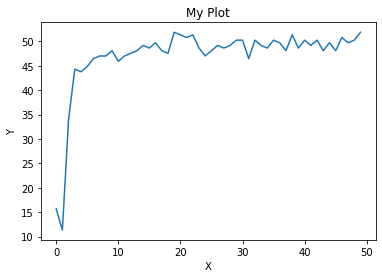

In [88]:
import matplotlib.pyplot as plt

# Plot the data
plt.plot(val_acc_list)

# Set the title and labels
plt.title("My Plot")
plt.xlabel("X")
plt.ylabel("Y")

# Show the plot
plt.show()